In [8]:
DATASET="rec.mu2e.CRV_wideband_cosmics.CRVWB-000-001-000-001ext.root"

In [9]:
from mu2etools import *
from mu2etools import wideband

processor = wideband.DataProcessor(xroot=False, fixtimes=True)
ar, arSpills = processor.getData(DATASET)

In [10]:
list_febID = ar['febID'].to_list()
FEBID = min(list_febID, key=lambda x: len(x))

NFEBS=len(FEBID)
print("Dataset: %s"%DATASET)
print("Number of FEBs: %d"%NFEBS)
print("List of FEBs: %s"%FEBID)

Dataset: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-001-000-001ext.root
Number of FEBs: 2
List of FEBs: [25, 17]


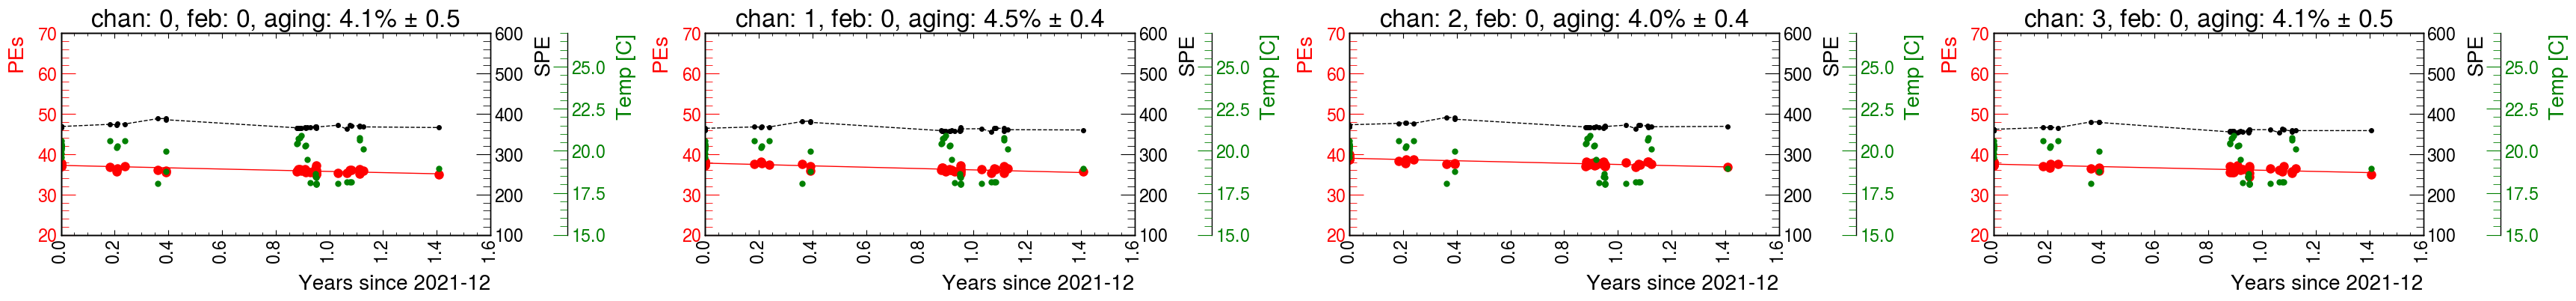

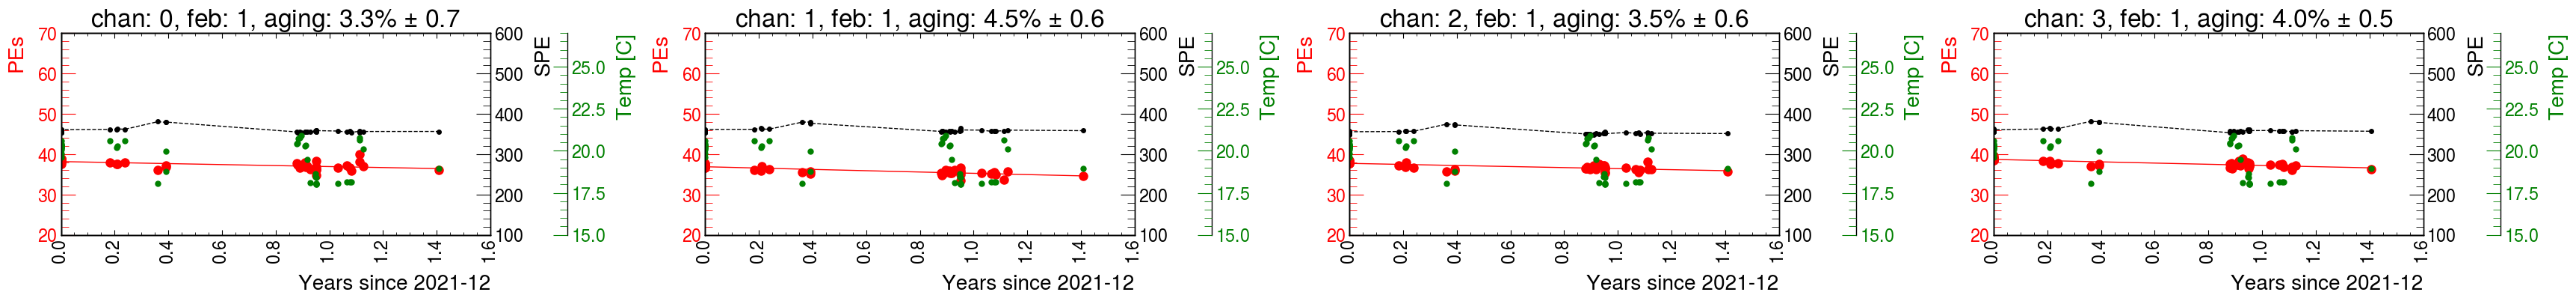

In [7]:
# Define the exponential function to fit
def func(x, a, b):
    return a * np.exp(-b*x/100) # return aging rate in %
#    return a -b*x/100 # return aging rate in %

df_age = pd.DataFrame(columns=['age_rate', 'init_pe', 'age_rate_std', 'res_std', 'chi2', 'chan', 'feb'])

#Filter only data within a narrow temperature range
cut=(ar['meanTemperatures'][:, 0, 0]>wideband.MIN_TEMP) & (ar['meanTemperatures'][:, 0, 0]<wideband.MAX_TEMP)
ar_=ar[cut]

for feb in range(0, NFEBS):
    
    fig, ax1 = plt.subplots(nrows=1, ncols=4, figsize=(40, 3.5))

    plt.subplots_adjust(wspace=0.5)
    plt.xticks(rotation=90)    
    
    for chan_infeb in range(wideband.NCHAN_FEB):

        chan = chan_infeb%wideband.NCHAN_CMB
        cut = (ar_['PEsTemperatureCorrected'][:, feb, chan_infeb] > 0)
        y = ar_['PEsTemperatureCorrected', cut][:, feb, chan_infeb].to_numpy()
        if len(y) == 0:
            continue

        t0 = ar_['timestamp', cut][0]
        x = (ar_['timestamp', cut] - t0)/wideband.SEC_YEAR
        x = x.to_numpy()

        popt, pcov = curve_fit(func, x, y, p0=[1, 5])
        
        init_pe, age_rate = popt
        y_fit = func(x, init_pe, age_rate)

        age_rate_std = np.sqrt(np.diag(pcov))[1] # Aging rate error 
        residuals = y - y_fit
        res_std = np.std(residuals)
        chisq = np.sum(residuals**2)
        dof = len(x) - len(popt)
        reduced_chi2 = chisq/dof
        
        # Plot only first 4 channels from FEBs
        if chan_infeb < 4:
            ax1[chan].set_title('chan: %d, feb: %d, aging: %.1f%% $\pm$ %.1f'%(chan_infeb,feb,age_rate,age_rate_std))
            ax1[chan].plot(x, y_fit, 'r-', linewidth=1, label='Fit')
            ax1[chan].set_ylim(20, 70)
            ax1[chan].set_ylabel('PEs', color='r')
            ax1[chan].set_xlabel('Years since %s'%t0.astype('datetime64[s]').astype('datetime64[M]'))
            ax1[chan].tick_params(axis='y', which='both', colors='r')
            ax1[chan].tick_params(axis='x', rotation=90)
            ax1[chan].plot(x, y, 'ro')

            y = ar_['calibConstantsTemperatureCorrected', cut][:, feb, chan_infeb].to_numpy()
            
            ax2 = ax1[chan].twinx()
            ax2.plot(x, y, 'k.--', linewidth=1)
            ax2.set_ylim(100, 600)
            ax2.set_ylabel('SPE', color='k')

            y = ar_['meanTemperatures', cut][:, 0, 0].to_numpy()
            ax3 = ax1[chan].twinx()
            ax3.plot(x, y, 'go', markersize=5.0)
            ax3.spines['right'].set_position(("axes", 1.18))
            ax3.set_ylabel('Temp [C]', color='g')
            ax3.set_ylim(15, 27)
            ax3.tick_params(axis='y', which='both', colors='g')

        #fill dataframe
        new_row = {'age_rate': age_rate,'init_pe': init_pe, 'age_rate_std':age_rate_std, 'res_std':res_std, 'chi2':reduced_chi2, 'chan':chan_infeb, 'feb':FEBID[feb]}
        df_age.loc[len(df_age)] = new_row
        
df_age['chi2_norm'] = df_age['chi2']/(df_age['res_std']**2).mean()

In [ ]:
def plotPEFits(xvar,yvar):

    df = pd.DataFrame(columns=['slope', 'offset', 'chan', 'feb'])
    ar_ = ar[ar['runNumber']>1176] # Select only data after electronics rack was installed

    for idx, feb in enumerate(FEBID):

        fig, axes = plt.subplots(nrows=1, ncols=16, figsize=(24, 2), sharey='row')
        plt.subplots_adjust(wspace=0)
        axes[0].set_ylabel('PE | FEB%d'%feb)

        for chan in range(wideband.NCHAN_FEB): # Loop thgough hdmi

            sipm = chan % 4
            ax = axes[chan//4]    
            x = ar_[xvar][:, idx, chan].to_numpy()
            y = ar_[yvar][:, idx, chan].to_numpy()

            x=x[y > 0] # Drop bad SPE points 
            y=y[y > 0] # Drop bad SPE points

            y=y[x > 0] # Drop bad Temp points
            x=x[x > 0] # Drop bad Temp points 

            if len(x) == 0: # Drop dead channels
                continue

            linmodel = np.poly1d(np.polyfit(x, y, 1))
            xline = np.linspace(17, 25, 100)
            ax.plot(xline, linmodel(xline), 'r--', linewidth=0.5)
            ax.plot(x,y, '.', linewidth=0.5, markersize=3, label='Ch%d: %.2f'%(chan, linmodel.coeffs[0]))
            ax.set_xlabel('Temp [C]', fontsize=10)
            ax.set_xlim(16, 27)
            ax.legend(prop={'size': 8}, loc='upper right')
            new_row = {'slope': linmodel.coeffs[0], 'offset': linmodel.coeffs[1], 'chan':chan, 'feb':feb}
            df.loc[len(df)] = new_row
            
    return df


def plotSPE(df, x, y):
    plt.figure()
    for feb in FEBID:
        df_ = df.query('feb==%d'%feb)
        plt.plot(df_[x], df_[y], '.--', label='feb: %d, mean: %.1f +/- %.1f'%(feb, df_[y].mean(), df_[y].std()))
        plt.ylabel(y)
        plt.xlabel(x)
        plt.legend();

In [ ]:
plotSPE(df_age, 'chan', 'init_pe');
plt.ylim(30, 70)

In [ ]:
for feb in FEBID:
    x=df_age.query('chi2_norm<1.5 & feb==%d'%feb)['age_rate']
    plt.hist(x, histtype='step', range=(-5,15), bins=40, label='feb: %d, rate: %0.1f%% $\pm$ %.1f%%'%(feb,x.mean(),x.std()));
plt.xlabel('Aging rate')

x=df_age.query('chi2_norm<1.5')['age_rate']
plt.hist(x, histtype='step', range=(-5,15), bins=40, label='All febs, rate: %0.1f%% $\pm$ %.1f%%'%(x.mean(),x.std()));
plt.legend();


plt.figure()
for feb in FEBID:
    x=df_age.query('feb==%d'%feb)['chan']
    y=df_age.query('feb==%d'%feb)['age_rate']
    plt.plot(x, y, '.--', label='feb: %d'%feb);
plt.legend();
plt.xlabel('Channel ID')
plt.ylim(-15,15);

Raw SPEs

In [ ]:
df = plotPEFits("meanTemperatures", "PEs")
plotSPE(df, 'chan', 'slope');        
plotSPE(df, 'chan', 'offset');        

Temperature Corrected SPEs

In [ ]:
df = plotPEFits("meanTemperatures", "PEsTemperatureCorrected")
plotSPE(df, 'chan', 'slope');        
plotSPE(df, 'chan', 'offset');        

In [ ]:
import datetime
current_time = datetime.datetime.now()
print(DATASET)
print("Current time:", current_time)

In [ ]:
for feb in FEBID:
    df_ = df_age.query('feb==%d'%feb)
    plt.hist(df_['chan'], bins=64, range=(0,64), histtype='step', label='feb: %d'%feb);
plt.legend();
plt.xlabel('Channel ID')
plt.ylabel('Channel alive')